# Fundamentos de analítica 2 (clase 2)
Universidad ICESI

Taller regresión por OLS presentado por:
- Alfredo Aponte
- Alvaro Rodriguez

Contexto

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses empleando los métodos vistos en la clase. Compare
los resultados con el mejor modelo encontrado en el ejercicio anterior (holt-winter).

Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

# **1. Carga de paquetes**

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error
import seaborn as sns

# **2. Carga de datos**

Vamos a usar los datos del libro para hacer las diferentes pruebas.

In [ ]:
# Lee un archivo de Excel que contiene datos de empleo y devuelve un DataFrame de pandas.
# El archivo debe tener una columna llamada 'mes' que contenga fechas en formato 'YYYY-MM-DD'
data = pd.read_excel("datosEmpleo.xlsx", index_col='mes', parse_dates=True)

data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


# **3.Calculo de Mejor modelo por OLS**

## 3.1  Tendencia cuadrática + estacionalidad

### Dataset completo con tendencia + estacionalidad

In [3]:
y = data["Ocupados"] #Crear variable y con la columna ocupados
x = np.linspace(1,data.shape[0],data.shape[0]) #Crear conteo de registros desde 1 hasta el fin del shape
data["x"] = np.linspace(1,data.shape[0],data.shape[0]) #Crear columna "x" incorporando el orden de los registros
data["x2"] = x**2 #Crear columna "x2" con el valor cuadrático de los registros
month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index) #Crear variables dummies de los meses
month_dummies = month_dummies.astype(float) #Casteo (cambio de tipo de variable float de month_dummies)
X = sm.add_constant( pd.concat([data[["x","x2"]],month_dummies],axis=1) ) #Genera "X" matriz con constante para el modelo OLS

### Protocolo evaluación,split (hold-out)

In [4]:
#Divide los datos en conjuntos de entrenamiento y prueba.
#Los datos de entrenamiento son los primeros datos (menos los ultimos 6 meses), 
# y los datos de prueba son los últimos 6 meses.
X_train = X.iloc[:-6]
X_test = X.iloc[-6:]
y_train = y.iloc[:-6]
y_test = y.iloc[-6:]

In [5]:
# Ajusta un modelo de Mínimos Cuadrados Ordinarios (OLS) con un polinomio de grado 2 
# utilizando los datos de entrenamiento.
# El modelo se ajusta a la relación entre la variable de respuesta y las variables explicativas.

season_pol2 = sm.OLS(y_train,X_train) # Genera OLS con polinomio grado 2 con la matriz X y y
season_pol_2 = season_pol2.fit() #Entrena el modelo OLS
y_pread_season_pol_2 = season_pol_2.predict(X_test) #Predecir con el modelo OLS
print(season_pol_2.summary()) #Imprimir modelo OLS

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     546.8
Date:                Fri, 16 Aug 2024   Prob (F-statistic):          1.87e-148
Time:                        21:16:00   Log-Likelihood:                -1449.9
No. Observations:                 214   AIC:                             2928.
Df Residuals:                     200   BIC:                             2975.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6573.7362     66.544     98.787      0.0

### Cálculo del RMSE

In [6]:
# Calcula el error cuadrático medio (RMSE) para una tendencia cuadrática con estacionalidad.

rmse_tendencia_cuadratica_estacionalidad = np.sqrt(mean_squared_error(y_test, y_pread_season_pol_2))
print("RMSE tendencia cuadrática con estacionalidad:",rmse_tendencia_cuadratica_estacionalidad)


RMSE tendencia cuadrática con estacionalidad: 590.4794957116567


## 3.2  Tendencia cúbica + estacionalidad

### Dataset completo con tendencia + estacionalidad

In [7]:
y = data["Ocupados"] #Crear variable y con la columna ocupados
x = np.linspace(1,data.shape[0],data.shape[0]) #Crear conteo de registros desde 1 hasta el fin del shape

data["x"] = np.linspace(1,data.shape[0],data.shape[0]) #Crear columna "x" incorporando el orden de los registros
data["x2"] = x**2 #Crear columna "x2" con el valor cuadrático de los registros
data["x3"] = x**3 #Crear columna "x2" con el valor cuadrático de los registros

month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index) #Crear variables dummies de los meses
month_dummies = month_dummies.astype(float) #Casteo (cambio de tipo de variable float de month_dummies)

X = sm.add_constant( pd.concat([data[["x","x2", "x3"]],month_dummies],axis=1) ) #Genera "X" matriz con constante para el modelo OLS


### Protocolo evaluación,split (hold-out)

In [8]:
#Divide los datos en conjuntos de entrenamiento y prueba.
#Los datos de entrenamiento son los primeros datos (menos los ultimos 6 meses), 
# y los datos de prueba son los últimos 6 meses.
X_train = X.iloc[:-6]
X_test = X.iloc[-6:]
y_train = y.iloc[:-6]
y_test = y.iloc[-6:]

In [9]:
# Ajusta un modelo de Mínimos Cuadrados Ordinarios (OLS) con un polinomio de grado 3 
# utilizando los datos de entrenamiento.
# El modelo se ajusta a la relación entre la variable de respuesta y las variables explicativas.

season_pol3 = sm.OLS(y_train,X_train) # Genera OLS con polinomio grado 2 con la matriz X y y
season_pol_3 = season_pol3.fit() #Entrena el modelo OLS
y_pread_season_pol_3 = season_pol_3.predict(X_test) #Predecir con el modelo OLS
print(season_pol_3.summary()) #Imprimir modelo OLS

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1079.
Date:                Fri, 16 Aug 2024   Prob (F-statistic):          3.41e-179
Time:                        21:16:01   Log-Likelihood:                -1370.3
No. Observations:                 214   AIC:                             2771.
Df Residuals:                     199   BIC:                             2821.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6975.3189     53.370    130.698      0.0

### Cálculo del RMSE

In [10]:
rmse_tendencia_cubica_estacionalidad = np.sqrt(mean_squared_error(y_test, y_pread_season_pol_3))
print("RMSE tendencia cúbica con estacionalidad:",rmse_tendencia_cubica_estacionalidad)

130.74393988599866

## 3.3  Tendencia polinomio nivel 4 + estacionalidad

### Dataset completo con tendencia + estacionalidad

In [11]:
y = data["Ocupados"] #Crear variable y con la columna ocupados
x = np.linspace(1,data.shape[0],data.shape[0]) #Crear conteo de registros desde 1 hasta el fin del shape
data["x"] = np.linspace(1,data.shape[0],data.shape[0]) #Crear columna "x" incorporando el orden de los registros
data["x2"] = x**2 #Crear columna "x2" con el valor cuadrático de los registros
data["x3"] = x**3 #Crear columna "x2" con el valor cuadrático de los registros
data["x4"] = x**4 #Crear columna "x2" con el valor cuadrático de los registros
month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index) #Crear variables dummies de los meses
month_dummies = month_dummies.astype(float) #Casteo (cambio de tipo de variable float de month_dummies)
X = sm.add_constant( pd.concat([data[["x","x2", "x3", "x4"]],month_dummies],axis=1) ) #Genera "X" matriz con constante para el modelo OLS


### Protocolo evaluación,split (hold-out)

In [12]:
#Divide los datos en conjuntos de entrenamiento y prueba.
#Los datos de entrenamiento son los primeros datos (menos los ultimos 6 meses), 
# y los datos de prueba son los últimos 6 meses.X_train = X.iloc[:-6]
X_test = X.iloc[-6:]
y_train = y.iloc[:-6]
y_test = y.iloc[-6:]

In [13]:
# Ajusta un modelo de Mínimos Cuadrados Ordinarios (OLS) con un polinomio de grado 4 
# utilizando los datos de entrenamiento.
# El modelo se ajusta a la relación entre la variable de respuesta y las variables explicativas.

season_pol4 = sm.OLS(y_train,X_train) # Genera OLS con polinomio grado 2 con la matriz X y y
season_pol_4 = season_pol4.fit() #Entrena el modelo OLS
y_pread_season_pol_4 = season_pol_4.predict(X_test) #Predecir con el modelo OLS
print(season_pol_4.summary()) #Imprimir modelo OLS
  

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1343.
Date:                Fri, 16 Aug 2024   Prob (F-statistic):          4.06e-190
Time:                        21:16:01   Log-Likelihood:                -1339.3
No. Observations:                 214   AIC:                             2711.
Df Residuals:                     198   BIC:                             2764.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6747.1802     54.081    124.761      0.0

### Cálculo del RMSE

In [14]:
rmse_tendencia_g4_estacionalidad = np.sqrt(mean_squared_error(y_test, y_pread_season_pol_4))
print("RMSE tendencia Polinomica G4 con estacionalidad:",rmse_tendencia_g4_estacionalidad )

221.62199564580675

## 3.4  Tendencia polinomio nivel 5 + estacionalidad

### Dataset completo con tendencia + estacionalidad

In [15]:
y = data["Ocupados"] #Crear variable y con la columna ocupados
x = np.linspace(1,data.shape[0],data.shape[0]) #Crear conteo de registros desde 1 hasta el fin del shape
data["x"] = np.linspace(1,data.shape[0],data.shape[0]) #Crear columna "x" incorporando el orden de los registros
data["x2"] = x**2 #Crear columna "x2" con el valor cuadrático de los registros
data["x3"] = x**3 #Crear columna "x2" con el valor cuadrático de los registros
data["x4"] = x**4 #Crear columna "x2" con el valor cuadrático de los registros
data["x5"] = x**5 #Crear columna "x2" con el valor cuadrático de los registros
month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index) #Crear variables dummies de los meses
month_dummies = month_dummies.astype(float) #Casteo (cambio de tipo de variable float de month_dummies)
X = sm.add_constant( pd.concat([data[["x","x2", "x3", "x4", "x5"]],month_dummies],axis=1) ) #Genera "X" matriz con constante para el modelo OLS
X_pol_5 = X

### Protocolo evaluación,split (hold-out)

In [16]:
#Divide los datos en conjuntos de entrenamiento y prueba.
#Los datos de entrenamiento son los primeros datos (menos los ultimos 6 meses), 
# y los datos de prueba son los últimos 6 meses.
X_train = X.iloc[:-6]
X_test = X.iloc[-6:]
X_full = X
y_train = y.iloc[:-6]
y_test = y.iloc[-6:]

In [17]:
# Ajusta un modelo de Mínimos Cuadrados Ordinarios (OLS) con un polinomio de grado 5 
# utilizando los datos de entrenamiento.
# El modelo se ajusta a la relación entre la variable de respuesta y las variables explicativas.

season_pol5 = sm.OLS(y_train,X_train) # Genera OLS con polinomio grado 2 con la matriz X y y
season_pol_5 = season_pol5.fit() #Entrena el modelo OLS
y_pread_season_pol_5 = season_pol_5.predict(X_test) #Predecir con el modelo OLS
print(season_pol_5.summary()) #Imprimir modelo OLS

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1447.
Date:                Fri, 16 Aug 2024   Prob (F-statistic):          1.19e-194
Time:                        21:16:01   Log-Likelihood:                -1324.0
No. Observations:                 214   AIC:                             2682.
Df Residuals:                     197   BIC:                             2739.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6588.6414     58.135    113.334      0.0

### Cálculo del RMSE

In [18]:
rmse_tendencia_pol_5_estacionalidad = np.sqrt(mean_squared_error(y_test, y_pread_season_pol_5))
print("RMSE tendencia grado 5 con estacionalidad:",rmse_tendencia_pol_5_estacionalidad)

91.0500709466212

**Conclusión: se identifica que el mejor modelo de cara al indicador RMSE es un modelo con tendencia de grado 5 y con estacionalidad, obteniendo un RMSE de 91.05**

# 4. Cálculos y validación de supuestos de residuales

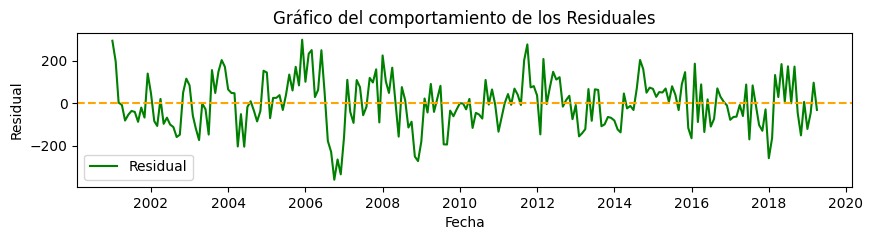

In [19]:
# Este código genera un gráfico de los residuos obtenidos de un modelo de regresión lineal.
# Los residuos son la diferencia entre los valores observados y los valores predichos por el modelo. 
prediccion_full = season_pol_5.predict(X) #Predecir con el modelo OLS
residuales =  y - prediccion_full  #Calcular los residuales
# Graficar
plt.figure(figsize=(10, 2))
plt.plot(X.index, residuales, label='Residual', color='green')
plt.title('Gráfico del comportamiento de los Residuales')
plt.xlabel('Fecha')
plt.ylabel('Residual')
plt.axhline(y=0, color='orange', linestyle='--')
plt.legend()
plt.show()

El gráfico de los residuales sugiere que el modelo funciona bastante bien en general, ya que los residuales se mantienen alrededor de cero y no se ven patrones evidentes de tendencia o estacionalidad que el modelo no haya captado. Sin embargo, hay ciertos periodos donde las desviaciones son más grandes, lo que indica que en esos momentos el modelo podría no estar ajustándose tan bien.

##  4.1 Validación del supuesto de NO Autocorrelación

### 4.1.1 Prueba de rachas

Para determinar si existe autocorrelación vamos a usar la prueba de rachas propuesta por Wald y Wolfowitz, 1940. Es una prueba no paramétrica donde las hipótesis son las siguientes:

H0:ρ=0  (Es decir no hay autocorrelación)

H1:ρ≠0  (Es decir hay autocorrelación)

Rechazo  H0  cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un  α =0.05 ( α  = nivel de significancia).

In [20]:
#Se comprueba si los valores de la variable «residuales» son superiores a 0.
#Se cuentan los valores True y False.

signo = residuales >0

In [21]:
# Ejecuta la prueba de corridas de 1 muestra en la secuencia de signos dada.
# Parámetros:
# - signo (array-like): La secuencia de signos a ser probada.
# - correction (bool, opcional): Si se aplica una corrección de continuidad. El valor predeterminado es False.
    
runstest_1samp(signo, correction=False)# Prueba de rachas de Wald y Wolfowitz

(-3.6453159711400027, 0.00026706346921678614)

El segundo valor corresponde al p-valor=0, por lo tanto considerando un  α =0.05, rechazo la hipótesis nula, por tanto con un 95% de confianza, podemos afirmar la serie parece NO comportarse como un ruido blanco, es decir, sí presenta autocorrelación.  Esta es la 1er. limitación que se le encuentra al modelo OLS óptimo.

### 4.1.2 Prueba de Box Pierce y Ljung-Box

Este análisis debe complementarse con otras pruebas como la prueba de Box-Pierce y la modificación de Ljung-Box para muestras pequeñas.

In [22]:
# Calcula los estadísticos Box-Pierce y Ljung-Box modificado para los residuos dados
#- El estadístico Box-Pierce mide la bondad de ajuste de un modelo de series temporales comprobando la hipótesis nula de que los residuos no están correlacionados.
#- El estadístico Ljung-Box modificado es una versión ajustada del estadístico Box-Pierce que tiene en cuenta el tamaño de la muestra y el número de rezagos que se comprueban.

sm.stats.acorr_ljungbox(residuales, lags=[1], return_df=True,boxpierce=True ) # Se puede hacer para un solo lag.

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,35.385957,2.704297e-09,34.907768,3.456989e-09


**Con el resultado anterior rechazamos la hipótesis nula de no autocorrelación para el primer rezago, lo ideal antes de tomar la decisión Es probar por lo menos los primeros 20 rezagos.**

In [23]:
# Calcula los estadísticos de la prueba de Ljung-Box y los valores p de los residuos 
# de un modelo, con los parámetros:
#- residuales (tipo array): Los residuos del modelo.
#- lags (rango o lista): El número de rezagos que se incluirán en la prueba.
#- return_df (bool, opcional): Si se devuelven los resultados como DataFrame. 
#- boxpierce (bool, opcional): Si se calculan los estadísticos y los valores p de la prueba Box-Pierce. 

Resul_lb_bp = sm.stats.acorr_ljungbox(residuales, lags=range(1,21), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,35.385957,2.704297e-09,34.907768,3.456989e-09,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,54.132234,1.759279e-12,53.316274,2.645563e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,64.515822,6.366811e-14,63.465999,1.067658e-13,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,65.113961,2.434814e-13,64.047971,4.083093e-13,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,65.418082,9.178448e-13,64.342503,1.534109e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,66.093669,2.578934e-12,64.993744,4.326664e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,68.233826,3.358100e-12,67.047138,5.825070e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,71.821993,2.129811e-12,70.473676,3.954984e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,72.663300,4.564455e-12,71.273297,8.564725e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,75.343989,4.077896e-12,73.809083,8.109428e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


En general, en todas las iteraciones de los lags, se observa la presencia de autocorrelación.

##  4.2 Validación del supuesto de homocedasticidad

Ahora nos queda por chequear si existe problemas de heteroscedasticidad, en especial un comportamiento tipo ARCH o GARCH, esto implica que la varianza de la serie tenga un comportamiento no autocorrelacionado.

Una aproximación para determinar si existe un comportamiento GARCH o ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

H0:  Comportamiento Homoscedastico (Es decir varianza constante)

H1:  Comportamiento Heteroscedastico (Es decir varianza no constante)

In [24]:
sm.stats.acorr_ljungbox((residuales-residuales.mean())**2, lags=range(1,21), return_df=True,boxpierce=True )

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,23.987862,9.694495e-07,23.663702,1.147262e-06
2,37.028299,9.107665e-09,36.469176,1.204534e-08
3,38.246407,2.506534e-08,37.659849,3.336194e-08
4,39.952554,4.427327e-08,39.319884,5.983080e-08
5,40.422614,1.227191e-07,39.775123,1.657696e-07
6,42.060303,1.789040e-07,41.353796,2.466181e-07
7,42.069278,5.042660e-07,41.362406,6.896911e-07
8,44.649192,4.288433e-07,43.826108,6.136569e-07
9,45.346950,7.958481e-07,44.489293,1.146608e-06
10,49.425774,3.402958e-07,48.347639,5.362244e-07


**Los resultados del la tabla anterior, SÍ permiten rechazar la nula de un comportamiento homocedástico(no auto-correlación de las varianzas) y por tanto SÍ hay comportamiento ARCH o GARCH o heterocedástico.**

## 4.3 Normalidad

Finalmente, podemos evaluar si la serie sigue una distribución normal o no. Nótese que esto no es necesario para ser ruido blanco, solo para ser ruido blanco gaussiano. Primero hagamos un análisis gráfico empleando las siguientes lineas de código. (Pregunta: qué implica esto)

In [25]:
residuales

mes
2001-01-01    293.612546
2001-02-01    196.927852
2001-03-01      3.075026
2001-04-01     -8.328043
2001-05-01    -81.091686
                 ...    
2018-12-01      6.348621
2019-01-01   -120.743842
2019-02-01    -45.290998
2019-03-01     96.527413
2019-04-01    -31.420322
Length: 220, dtype: float64

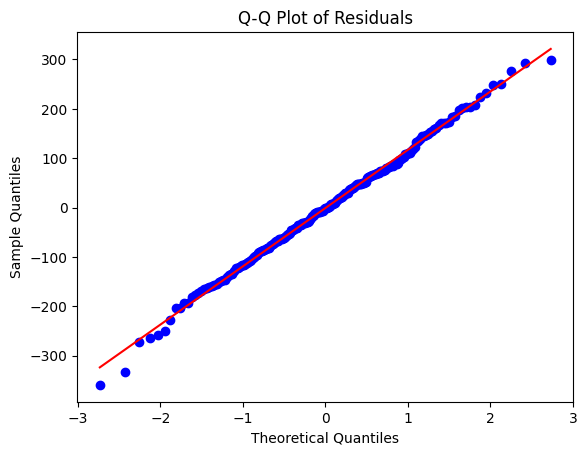

In [26]:
#sm.qqplot(residuales, line ='45')
#py.show()
#Preguntar: ¿por qúe no funciona el qqplot?
stats.probplot(residuales, dist="norm", plot=plt)
# Añadir etiquetas y título (opcional)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot of Residuals')
# Mostrar el gráfico
plt.show()

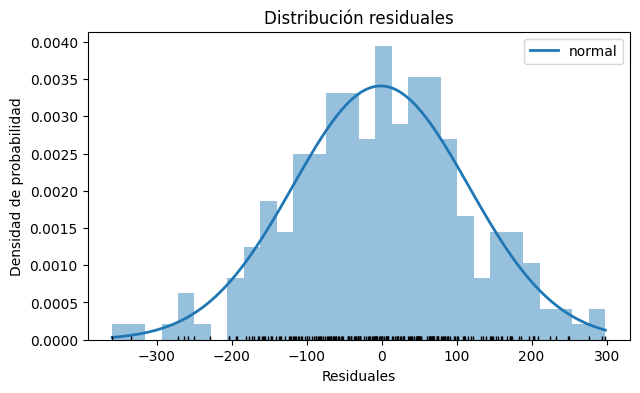

In [27]:
# Histograma + curva normal teórica
# ==============================================================================
# Valores de la media (mu) y desviación típica (sigma) de los datos
mu, sigma = stats.norm.fit(residuales)
# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(residuales), max(residuales), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)
# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=residuales, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(residuales, np.full_like(residuales, 0), '|k', markeredgewidth=1)
ax.set_title('Distribución residuales')
ax.set_xlabel('Residuales')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

**Según el QQ plot y el histograma, al parecer tenemos una distrubución normal de los residuales**

### 4.3.1 Prueba Shapiro y Jarque Bera

In [28]:
stats.shapiro(residuales)

ShapiroResult(statistic=0.9968739748001099, pvalue=0.9419360160827637)

In [29]:
stats.jarque_bera(residuales)

SignificanceResult(statistic=0.2616071045859223, pvalue=0.8773901187391682)

Para ambas pruebas, no se puede rechazar la hipótesis de que los datos provienen de una distribución normal.

# 5. Pronóstico

## 5.1 Generación de dataset X para pronóstico (tendencia polinomio nivel 5 + estacionalidad)

In [30]:
h=6 #Ventana de estimación
meses_anio = 12
#numpy.linspace(valor-inicial, valor-final, número de valores)
#Pregunta: ¿por qué en el ejercicio en clase la dumificación no inició en mayo?
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+meses_anio),meses_anio) #Crear consecutivo desde el dato t + 1 hasta el dato t + la ventana, garantizando que la cantidad de los registros de la venta se cumpla
x_for = x_for.astype(float) #Casteo de la variable x_for Pregunta ¿por qué las dummies arrancan en 222 enero, esto podría traer problema si la estimación no arranca en enero?
x_for_dummies = pd.get_dummies(x_for.astype(int),drop_first=True) #Variables dummies de las pronósticos
x_for_dummies = x_for_dummies.astype(float) #Casteo de variable_x_for_dummies
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2, x_for**3, x_for**4, x_for**5),axis=1),columns=["x","x2", "x3", "x4", "x5"] ) #Transponer y consolidar las columnas x_for y x_for cuadrático
range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=h,freq='MS') #Crear una secuencia de meses desde t +1 hasta la ventana, colocando el month star (incio del mes)
X_for= sm.add_constant(pd.concat([x_for_all,x_for_dummies],axis=1)) #Agrega constante y consolida todas las matrices anteriores
X_for = X_for.iloc[:6]
X_for.set_index(range_dates,inplace=True) #Reemplaza el índice en la matriz preds.
renombrar_columnas = ["const","x","x2", "x3", "x4", "x5", 2,3,4,5,6,7,8,9,10,11,12] #Crear lista de
X_for.columns = renombrar_columnas
X_for

,const,x,x2,x3,x4,x5,2,3,4,5,6,7,8,9,10,11,12
2019-05-01,1.0,221.0,48841.0,10793861.0,2.385443e+09,5.271830e+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-01,1.0,222.0,49284.0,10941048.0,2.428913e+09,5.392186e+11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-01,1.0,223.0,49729.0,11089567.0,2.472973e+09,5.514731e+11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-01,1.0,224.0,50176.0,11239424.0,2.517631e+09,5.639493e+11,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-01,1.0,225.0,50625.0,11390625.0,2.562891e+09,5.766504e+11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-01,1.0,226.0,51076.0,11543176.0,2.608758e+09,5.895793e+11,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Asignar cero a las columnas 2,3,4,5,6,7,8,9,10,11 y 12 de x_for

X_for[[2,3,4,5,6,7,8,9,10,11, 12]] = 0.0
X_for


,const,x,x2,x3,x4,x5,2,3,4,5,6,7,8,9,10,11,12
2019-05-01,1.0,221.0,48841.0,10793861.0,2.385443e+09,5.271830e+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-01,1.0,222.0,49284.0,10941048.0,2.428913e+09,5.392186e+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-01,1.0,223.0,49729.0,11089567.0,2.472973e+09,5.514731e+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-01,1.0,224.0,50176.0,11239424.0,2.517631e+09,5.639493e+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-01,1.0,225.0,50625.0,11390625.0,2.562891e+09,5.766504e+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-01,1.0,226.0,51076.0,11543176.0,2.608758e+09,5.895793e+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# tomando el mes del  indice de x_for, asignar 1.0 a la columna que tenga el mismo numero
for index, row in X_for.iterrows():
  month = index.month
  if month in X_for.columns:
    X_for.loc[index, month] = 1.0
X_for

,const,x,x2,x3,x4,x5,2,3,4,5,6,7,8,9,10,11,12
2019-05-01,1.0,221.0,48841.0,10793861.0,2.385443e+09,5.271830e+11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-01,1.0,222.0,49284.0,10941048.0,2.428913e+09,5.392186e+11,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-01,1.0,223.0,49729.0,11089567.0,2.472973e+09,5.514731e+11,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-08-01,1.0,224.0,50176.0,11239424.0,2.517631e+09,5.639493e+11,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2019-09-01,1.0,225.0,50625.0,11390625.0,2.562891e+09,5.766504e+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2019-10-01,1.0,226.0,51076.0,11543176.0,2.608758e+09,5.895793e+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## 5.2 Consolidación de data set total X full + pronostico x

In [33]:
X_for_full_pronostico = pd.concat([X_pol_5, X_for])
X_for_full_pronostico

,const,x,x2,x3,x4,x5,2,3,4,5,6,7,8,9,10,11,12
2001-01-01,1.0,1.0,1.0,1.0,1.000000e+00,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-02-01,1.0,2.0,4.0,8.0,1.600000e+01,3.200000e+01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-03-01,1.0,3.0,9.0,27.0,8.100000e+01,2.430000e+02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-04-01,1.0,4.0,16.0,64.0,2.560000e+02,1.024000e+03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-05-01,1.0,5.0,25.0,125.0,6.250000e+02,3.125000e+03,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-01,1.0,222.0,49284.0,10941048.0,2.428913e+09,5.392186e+11,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-01,1.0,223.0,49729.0,11089567.0,2.472973e+09,5.514731e+11,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-08-01,1.0,224.0,50176.0,11239424.0,2.517631e+09,5.639493e+11,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2019-09-01,1.0,225.0,50625.0,11390625.0,2.562891e+09,5.766504e+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## 5.2 Cálculo de pronóstico por OLS

In [34]:
#Nivel de confianza
dt = season_pol_5.get_prediction(X_for_full_pronostico).summary_frame(alpha = 0.05)
y_prd = dt['mean'] #Es el dato del modelo, se coloca "mean". Pregunta ¿por qué pone un promedio?
yprd_ci_lower = dt['obs_ci_lower'] #Predicción con un intervalo rango inferior al 95%
yprd_ci_upper = dt['obs_ci_upper'] #Predicción con un intervalo rango superior al 95%
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))  #Consolidar columnas
preds.columns = ['Point_forecast', 'lower_95', 'upper_95'] #Nombra columnas
preds.set_index(X_for_full_pronostico.index,inplace=True)
print(preds) #Imprime preds

            Point_forecast      lower_95      upper_95
2001-01-01     6629.991454   6365.298094   6894.684814
2001-02-01     6840.818148   6578.436380   7103.199916
2001-03-01     6942.897974   6682.496743   7203.299205
2001-04-01     6981.407043   6722.690977   7240.123109
2001-05-01     7075.553686   6818.261009   7332.846362
...                    ...           ...           ...
2019-06-01    10676.237489  10370.444367  10982.030612
2019-07-01    10749.382194  10435.832809  11062.931578
2019-08-01    10721.554756  10399.457887  11043.651626
2019-09-01    10778.889124  10447.415378  11110.362870
2019-10-01    10887.350702  10545.634754  11229.066651

[226 rows x 3 columns]


In [35]:
#Esta función recupera las últimas 'h' filas del dataframe 'preds' y las devuelve.
preds = preds.tail(h)
preds

,Point_forecast,lower_95,upper_95
2019-05-01,10719.986376,10421.198505,11018.774247
2019-06-01,10676.237489,10370.444367,10982.030612
2019-07-01,10749.382194,10435.832809,11062.931578
2019-08-01,10721.554756,10399.457887,11043.651626
2019-09-01,10778.889124,10447.415378,11110.362870
2019-10-01,10887.350702,10545.634754,11229.066651


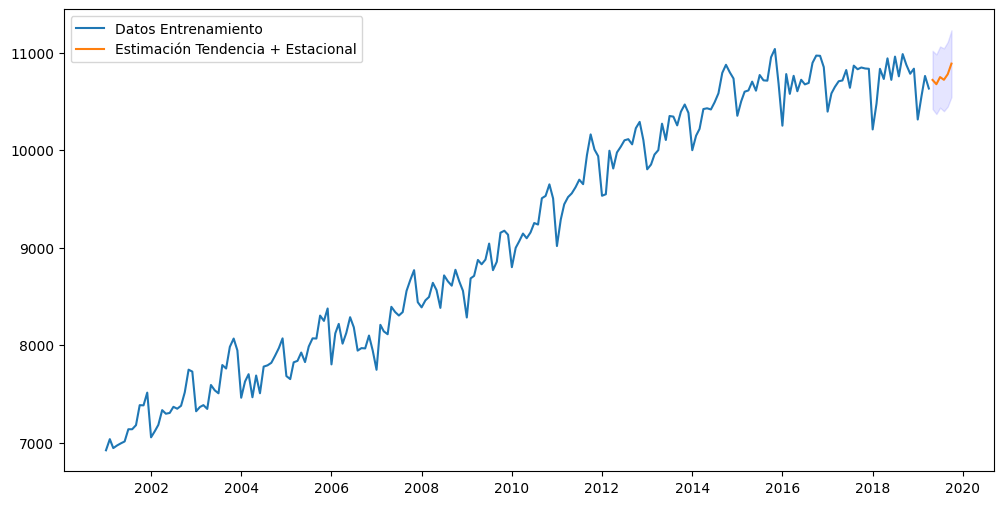

In [36]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Tendencia + Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()